# License detector pipeline visualization

In [1]:
import cv2
import matplotlib

from matplotlib import pyplot as plt

import numpy as np


def show(image: np.ndarray):
    [height, width, *_] = image.shape
    aspect = width / height
    size = np.array([aspect, 1])
    size = size / size.max() * 4
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(1, 1, 1)
    if len(image.shape) == 2:
        ax.imshow(image, aspect="auto", cmap="gray")
    else:
        ax.imshow(image[...,::-1], aspect="auto", cmap="hsv")
    ax.axis("off")
    plt.show()


def show_contours(image: np.ndarray, contours: np.ndarray):
    contours_image = cv2.drawContours(np.copy(image), contours, -1, (0,0,255), 2)
    show(contours_image)


path = "../datasets/01-polish-licence-plates/train/0001Z4JTCII2TV0E-C122-F4_jpg.rf.a098ae845ee8bda6ed47e08e34b9ccf2.jpg"

matplotlib.rcParams["savefig.pad_inches"] = 0

## Image loading

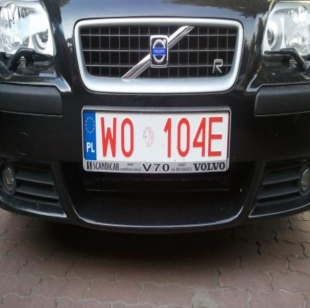

In [2]:
from twm_proj.implementation.image_reader import ImageReader

with open(path, "rb") as file:
    image = ImageReader().read(file)

show(image)

## Initial filtering (TODO)

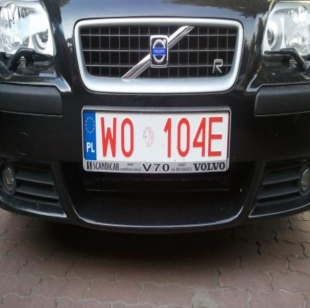

In [3]:
from twm_proj.implementation.initial_filter import InitialFilter

filtered = InitialFilter().filter(image)
show(filtered)

## Edge filter

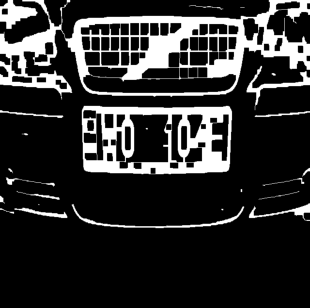

In [4]:
from twm_proj.implementation.edge_filter import EdgeFilter

edges = EdgeFilter().filter(image)
show(edges)

## Contour detector

contours count: 106
example contour:
 [[457 434]
 [457 435]
 [458 436]
 [460 436]
 [460 434]]


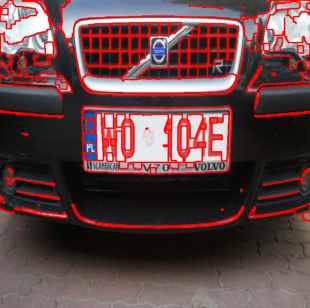

In [5]:
from twm_proj.implementation.contour_detector import ContourDetector

contours = [*ContourDetector().detect(edges)]
print("contours count:", len(contours))
print("example contour:\n", contours[0])
show_contours(image, contours)

## Rectangle detection

rects count: 1
example rect:
 [[170 226]
 [177 355]
 [472 351]
 [471 220]]


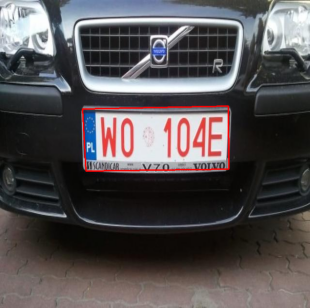

In [6]:
from twm_proj.implementation.rect_detector import RectDetector

rects = [RectDetector().detect(contour) for contour in contours]
rects = [rect for rect in rects if rect is not None]
print("rects count:", len(rects))
print("example rect:\n", rects[0])
show_contours(image, rects)

## Rectangle transforming

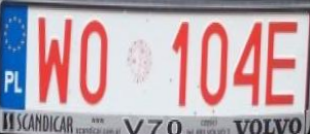

In [7]:
from twm_proj.implementation.rect_transformer import RectTransformer

rect_images = [RectTransformer().transform(image, rect) for rect in rects]
show(rect_images[0])

## Rectangle classification

In [8]:
from twm_proj.implementation.rect_classifier import RectClassifier
from twm_proj.interface.rect_classifier import RectangleType

rect_classes = [RectClassifier().classify_with_differences(img) for img in rect_images]
display([(rect_class.name, differences) for rect_class, differences in rect_classes])

plates = [
    rect
    for rect, cls in zip(rect_images, rect_classes)
    if cls != RectangleType.NOT_PLATE
]

[('MINI_PLATE',
  {<RectangleType.ONE_ROW_PLATE: 1>: 0.4962712859659424,
   <RectangleType.TWO_ROW_PLATE: 2>: 0.6121636841446628,
   <RectangleType.MINI_PLATE: 3>: 0.16844783715012715})]

## Pre-OCR processing

In [9]:
from twm_proj.implementation.pre_ocr import PreOcr

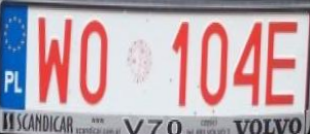

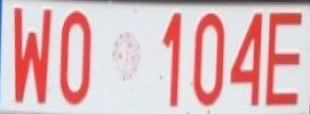

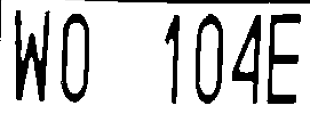

In [10]:
plate_to_ocr = rect_images[0]
show(plate_to_ocr)
plate_to_ocr = PreOcr().cut(plate_to_ocr)
show(plate_to_ocr)
plate_to_ocr = PreOcr().to_grayscale(plate_to_ocr)
show(plate_to_ocr)

## OCR

In [11]:
from twm_proj.implementation.ocr import Ocr

scanned_text = Ocr().scan_text(plate_to_ocr)
print(scanned_text)

WO104E
